In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

DATASET = "dataset/ai_assistant_usage_student_life.csv"

def load_ai_usage_data():
    if not Path(DATASET).is_file():
        raise TypeError
    return pd.read_csv(Path("dataset/ai_assistant_usage_student_life.csv"))
data = load_ai_usage_data()

In [2]:
## Modifying SessionDate to days since oldest entry
data['SessionDate'] = pd.to_datetime(data['SessionDate'])

oldest_date = pd.to_datetime(datetime.datetime.now())
for date in data['SessionDate']:
    if date >= oldest_date:
        continue
    oldest_date = date
data['DaysSinceFirstSession'] = (data['SessionDate'] - oldest_date).dt.days



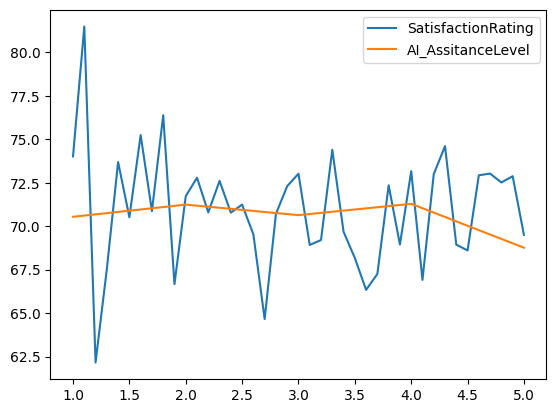

In [3]:
## percentage of students returning to AI depending 
## on their SatisfactionRating and on day of session - not sufficient
used_again_sr = (
    data.groupby('SatisfactionRating')['UsedAgain']
      .mean() * 100
)
used_again_ai_assist = (
    data.groupby('AI_AssistanceLevel')['UsedAgain']
      .mean() * 100
)

plt.plot(used_again_sr, label='SatisfactionRating')
plt.plot(used_again_ai_assist, label='AI_AssitanceLevel')
plt.legend()

Plot indicates there is little correlation between SatisfactionRating or AI_AssistanceLevel and % of Trues in UsedAgain label.

In [4]:
finalOutcome_percent_true = (
    data.groupby("FinalOutcome")["UsedAgain"]
        .mean() * 100
)
taskType_percent_true = (
    data.groupby("TaskType")["UsedAgain"]
        .mean() * 100
)
discipline_percent_true = (
    data.groupby("Discipline")["UsedAgain"]
        .mean() * 100
)
studentLevel_percent_true = (
    data.groupby("StudentLevel")["UsedAgain"]
        .mean() * 100
)
print(finalOutcome_percent_true)
print()
print(taskType_percent_true)
print()
print(discipline_percent_true)
print()
print(studentLevel_percent_true)

FinalOutcome
Assignment Completed    80.620805
Confused                40.173590
Gave Up                 40.637450
Idea Drafted            79.064899
Name: UsedAgain, dtype: float64

TaskType
Brainstorming    69.537815
Coding           74.229979
Homework Help    68.657478
Research         64.285714
Studying         68.186275
Writing          72.396001
Name: UsedAgain, dtype: float64

Discipline
Biology             71.262003
Business            69.716312
Computer Science    71.211073
Engineering         71.188811
History             72.124206
Math                68.073136
Psychology          70.874471
Name: UsedAgain, dtype: float64

StudentLevel
Graduate         70.325815
High School      71.336951
Undergraduate    70.508531
Name: UsedAgain, dtype: float64


We can see that the better the FinalOutcome is, the more likely a student is to use AI in the future. There are minor differences between TaskType, Discipline and StudentLevel %'s. Therefore I'm deciding to drop irrelevant categorical features and study numerical ones furthermore.

In [5]:
## Modyfying FinalOutcome and StudentLevel to number
final_outcome_translator = {
    'Assignment Completed' : 3,
    'Idea Drafted' : 2,
    'Confused' : 1,
    'Gave Up' : 0,
}
if isinstance(data['FinalOutcome'][0], str):
    data['FinalOutcome'] = [final_outcome_translator[entry]
                        for entry in data['FinalOutcome']]

X = data.drop(columns=["UsedAgain", "SessionID", "SessionDate", "Discipline", "TaskType", "StudentLevel"])
y = data["UsedAgain"].astype(int)

Text(0.5, 1.0, 'Correlation Heatmap')

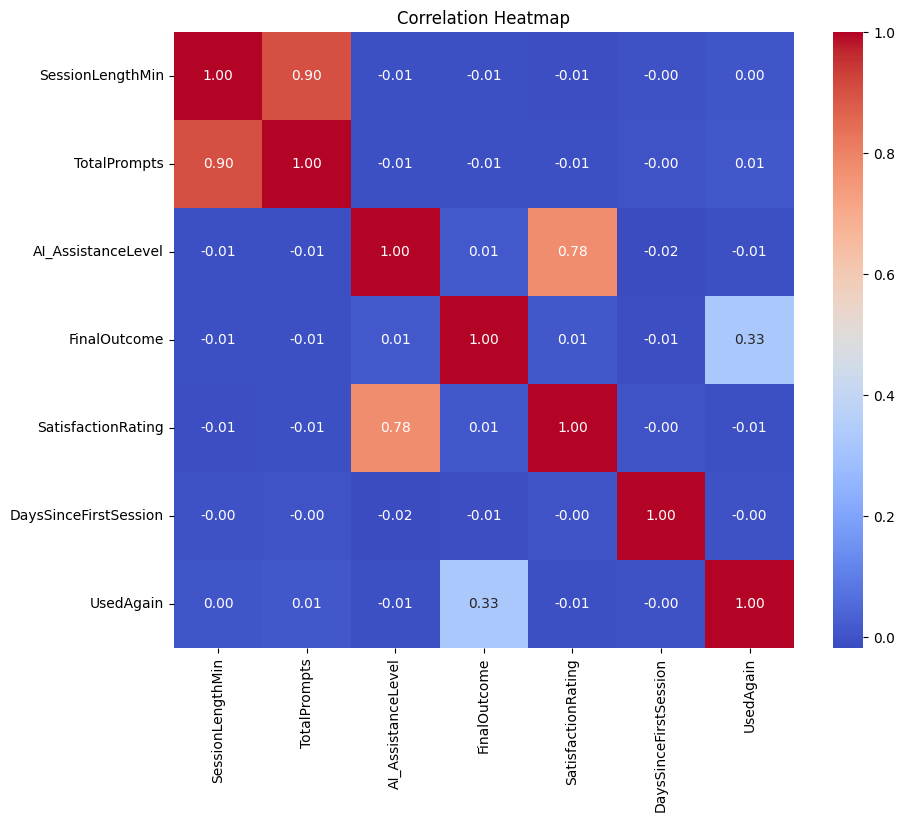

In [6]:
# Creating a correlation matrix

corr_data = X.assign(UsedAgain=y)
corr = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")

Matrix confirmes my assumptions based on previous plots, that SatisfactionRating and AI_AssistanceLevel have no correlation with my label. What's worse, none of the numeric values have. It seems only FinalOutcome has any correlation with the label.

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       587
           1       0.77      0.89      0.83      1413

    accuracy                           0.74      2000
   macro avg       0.68      0.63      0.64      2000
weighted avg       0.72      0.74      0.72      2000

ROC-AUC: 0.6607885405778178


Text(50.722222222222214, 0.5, 'Actual')

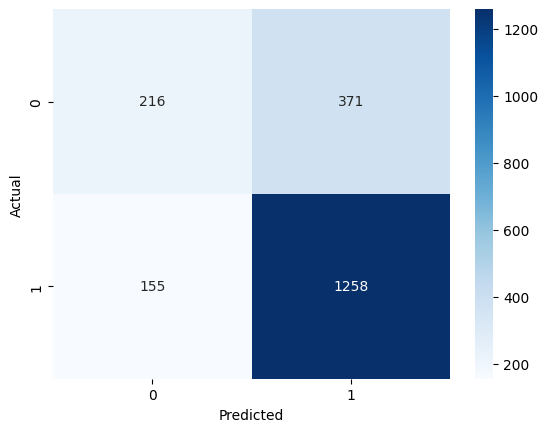

In [22]:
# Based on data analysis, I have little chance 
# to train well-working model, but I'll try anyway.
# trying RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

cut_data = data.drop(columns=["SessionID", "SessionDate", "Discipline", "TaskType", "StudentLevel"])
cut_data["days_cat"] = pd.cut(cut_data['DaysSinceFirstSession'],
                              bins=[0,50,100,150,200,250,300, np.inf])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [8]:
# checking importances of features and its actual helpness

importances = rf.feature_importances_
feature_names = X_train.columns

feature_importances = pd.Series(importances, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

rf_without_SLM = RandomForestClassifier(n_estimators=200, random_state=42)
X_train_dropped = X_train.drop(columns=["DaysSinceFirstSession", "SessionLengthMin"])
X_test_dropped = X_test.drop(columns=["DaysSinceFirstSession", "SessionLengthMin"])

rf_without_SLM.fit(X_train_dropped, y_train)

y_pred = rf_without_SLM.predict(X_test_dropped)
y_prob = rf_without_SLM.predict_proba(X_test_dropped)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



SessionLengthMin         0.272712
DaysSinceFirstSession    0.256730
FinalOutcome             0.167462
SatisfactionRating       0.156918
TotalPrompts             0.097947
AI_AssistanceLevel       0.048232
dtype: float64
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       587
           1       0.76      0.84      0.80      1413

    accuracy                           0.70      2000
   macro avg       0.62      0.60      0.60      2000
weighted avg       0.68      0.70      0.68      2000

ROC-AUC: 0.6328446850913458


It seems there is some (little but still) use of SessionLengthMin and DaysSinceFirstSession features. Therefore I will try to bring back categorical features, I dumped earlier.

              precision    recall  f1-score   support

           0       0.59      0.38      0.46       587
           1       0.77      0.89      0.83      1413

    accuracy                           0.74      2000
   macro avg       0.68      0.63      0.64      2000
weighted avg       0.72      0.74      0.72      2000

ROC-AUC: 0.6600072821006209


Text(50.722222222222214, 0.5, 'Actual')

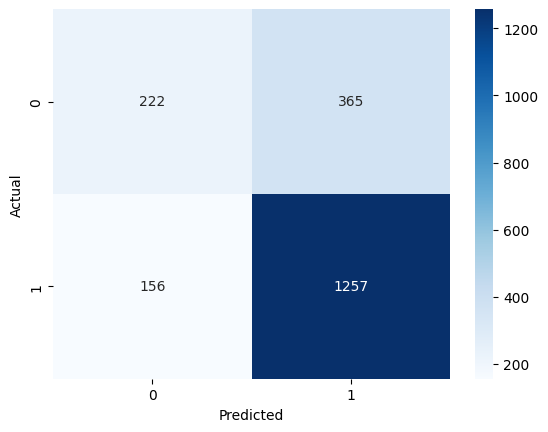

In [23]:
# "Discipline", "TaskType", "StudentLevel"
X = data.drop(columns=["UsedAgain", "SessionID", "SessionDate"])
y = data["UsedAgain"].astype(int)

X = pd.get_dummies(X, columns=["Discipline", "TaskType", "StudentLevel"], drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_full = RandomForestClassifier(n_estimators=250, random_state=42)

rf_full.fit(X_train, y_train)

y_pred = rf_full.predict(X_test)
y_prob = rf_full.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [10]:
importances = rf_full.feature_importances_
feature_names = X_train.columns

feature_importances = pd.Series(importances, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

SessionLengthMin               0.188983
DaysSinceFirstSession          0.183719
FinalOutcome                   0.164132
SatisfactionRating             0.135920
TotalPrompts                   0.098834
AI_AssistanceLevel             0.052692
StudentLevel_Undergraduate     0.021988
StudentLevel_High School       0.016581
Discipline_Business            0.014485
Discipline_Computer Science    0.014429
Discipline_Psychology          0.014318
Discipline_Engineering         0.014151
TaskType_Writing               0.013503
TaskType_Studying              0.012845
Discipline_Math                0.012603
Discipline_History             0.012515
TaskType_Homework Help         0.012508
TaskType_Coding                0.009494
TaskType_Research              0.006300
dtype: float64


We can see that influence of added features on learning is minor, nevertheless there is slight improvement in model accuracy.

              precision    recall  f1-score   support

           0       0.58      0.22      0.32       587
           1       0.74      0.93      0.83      1413

    accuracy                           0.72      2000
   macro avg       0.66      0.58      0.57      2000
weighted avg       0.70      0.72      0.68      2000

ROC-AUC: 0.6764456597354089


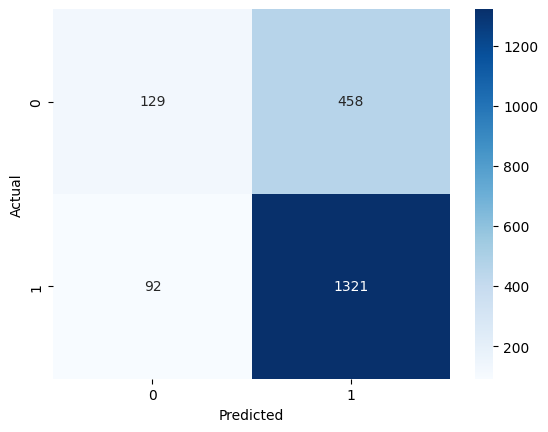

In [11]:

# trying logistic regression model

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


LogisticRegression gives much worse results.

In [20]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])

rf_hp = RandomForestClassifier(
    random_state=42
)

param_grid = {
    "rf__n_estimators": [100, 200, 500],
    "rf__max_depth": [None, 5, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV score: 0.748375


              precision    recall  f1-score   support

           0       0.58      0.37      0.45       587
           1       0.77      0.89      0.83      1413

    accuracy                           0.74      2000
   macro avg       0.68      0.63      0.64      2000
weighted avg       0.72      0.74      0.72      2000

ROC-AUC: 0.6607885405778178


Text(50.722222222222214, 0.5, 'Actual')

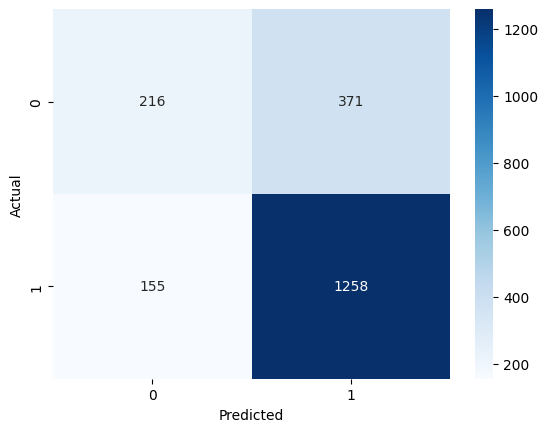

In [21]:
rf_final = RandomForestClassifier(
    max_depth=10, 
    max_features='sqrt', 
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
